This Notebook provides a minimal example for using LFP to train a simple LeNet on MNIST.

For more complex examples, refer to the experiment notebooks in ./nbs

### Imports

In [1]:
import os

import numpy as np
import torch
import torch.nn as tnn
import torcheval.metrics
import torchvision.datasets as tvisiondata
import torchvision.transforms as T
from tqdm import tqdm

from lxt import rules as lrules
from zennit import types as ztypes

from experiment_utils.model.models import ACTIVATION_MAP

from lfprop.propagation import (
    propagator_lxt as propagator,
)  # LFP propagator. Alternatively, use propagator_zennit
from lfprop.rewards import reward_functions as rewards  # Reward Functions

/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [2]:
savepath = "sftp://lweber@172.16.25.141/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f52/reward-backprop/resubmission-1-experiments/noisy-stepfunc-training/signchanging-act-data"
os.makedirs(savepath, exist_ok=True)

batch_size = 128
n_channels = 1
n_outputs = 10

lr = 0.1
momentum = 0.9
epochs = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Dataset

In [3]:
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
training_data = tvisiondata.MNIST(
    root=savepath,
    transform=transform,
    download=True,
    train=True,
)

validation_data = tvisiondata.MNIST(
    root=savepath,
    transform=transform,
    download=True,
    train=False,
)

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [4]:
# Build activations dict
activations = ["negtanh", "negrelu", "neginnerrelu", "negstep"]

result_dict = {
    act: {"LFP": [], "adaptedLFP": []} for act in activations
}

### Load Model

In [5]:
class LeNet(tnn.Module):
    """
    Small LeNet
    """

    def __init__(self, n_channels, n_outputs, activation=tnn.ReLU):
        super().__init__()

        # Feature extractor
        self.features = tnn.Sequential(
            tnn.Conv2d(n_channels, 16, 5),
            activation(),
            tnn.MaxPool2d(2, 2),
            tnn.Conv2d(16, 16, 5),
            activation(),
            tnn.MaxPool2d(2, 2),
        )

        # Classifier
        self.classifier = tnn.Sequential(
            tnn.Linear(256 if n_channels == 1 else 400, 120),
            activation(),
            tnn.Dropout(),
            tnn.Linear(120, 84),
            activation(),
            tnn.Dropout(),
        )

        self.last = tnn.Linear(84, n_outputs)

    def forward(self, x):
        """
        forwards input through network
        """

        # Forward through network
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.last(x)

        # Return output
        return x


for act in activations:
    for prop in result_dict[act].keys():
        act_model = LeNet(
            n_channels=n_channels,
            n_outputs=n_outputs,
            activation=ACTIVATION_MAP[act],
        )
        act_model.to(device)
        act_model.eval()
        print(act, prop, act_model)
        result_dict[act][prop].append(act_model)

negtanh LFP LeNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): NegTanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): NegTanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): NegTanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): NegTanh()
    (5): Dropout(p=0.5, inplace=False)
  )
  (last): Linear(in_features=84, out_features=10, bias=True)
)
negtanh adaptedLFP LeNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): NegTanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): NegTanh()
   

### Set Up LFP

In [6]:
class BothflipLFPEpsilonComposite(propagator.ParameterizableComposite):
    def __init__(self, epsilon=1e-6):
        layer_map = {
            "last": propagator.RuleGenerator( # Order matters!
                propagator.LFPEpsilon,
                epsilon=epsilon,
                reverse_pos=False, reverse_neg=False
            ),
            ztypes.Activation: lrules.IdentityRule,
            ztypes.Linear: propagator.RuleGenerator(
                propagator.LFPEpsilon,
                epsilon=epsilon,
                reverse_pos=True, reverse_neg=True
            ),
        }

        super().__init__(layer_map=layer_map)

class NegflipLFPEpsilonComposite(propagator.ParameterizableComposite):
    def __init__(self, epsilon=1e-6):
        layer_map = {
            "last": propagator.RuleGenerator( # Order matters!
                propagator.LFPEpsilon,
                epsilon=epsilon,
                reverse_pos=False, reverse_neg=False
            ),
            ztypes.Activation: lrules.IdentityRule,
            ztypes.Linear: propagator.RuleGenerator(
                propagator.LFPEpsilon,
                epsilon=epsilon,
                reverse_pos=False, reverse_neg=True
            ),
        }

        super().__init__(layer_map=layer_map)

class PosflipLFPEpsilonComposite(propagator.ParameterizableComposite):
    def __init__(self, epsilon=1e-6):
        layer_map = {
            "last": propagator.RuleGenerator( # Order matters!
                propagator.LFPEpsilon,
                epsilon=epsilon,
                reverse_pos=False, reverse_neg=False
            ),
            ztypes.Activation: lrules.IdentityRule,
            ztypes.Linear: propagator.RuleGenerator(
                propagator.LFPEpsilon,
                epsilon=epsilon,
                reverse_pos=True, reverse_neg=False
            ),
        }

        super().__init__(layer_map=layer_map)

# Initialize the LFP Composite
# Currently, only LFP-Epsilon is implemented. More composites may be added in the future.
for act in activations:
    if act in ["negtanh"]:
        corr_prop_comp = BothflipLFPEpsilonComposite()
    elif act in ["neginnerrelu"]:
        corr_prop_comp = NegflipLFPEpsilonComposite()
    elif act in ["negrelu", "negstep"]:
        corr_prop_comp = PosflipLFPEpsilonComposite()
    for prop in result_dict[act].keys():
        if prop == "LFP":
            prop_comp = propagator.LFPEpsilonComposite()
        else:
            prop_comp = corr_prop_comp
        result_dict[act][prop].append(prop_comp)

        print(act, prop, prop_comp)

# Initialize the Reward Function.
# Here we use the Reward Function suggested in the LFP-Paper, but check out other reward functions in ./lfp/rewards/reward_functions.py
reward_func = rewards.SoftmaxLossReward(device)

# LFP writes its updates into the .grad attribute of the model parameters, and can thus utilize standard torch optimizers
for act in activations:
    for prop in result_dict[act].keys():
        act_optimizer = torch.optim.SGD(result_dict[act][prop][0].parameters(), lr=lr, momentum=momentum)
        result_dict[act][prop].append(act_optimizer)

negtanh LFP <lfprop.propagation.propagator_lxt.LFPEpsilonComposite object at 0x7f3c52e1f2d0>
negtanh adaptedLFP <__main__.BothflipLFPEpsilonComposite object at 0x7f3dcc07add0>
negrelu LFP <lfprop.propagation.propagator_lxt.LFPEpsilonComposite object at 0x7f3c53cfeb10>
negrelu adaptedLFP <__main__.PosflipLFPEpsilonComposite object at 0x7f3c520198d0>
neginnerrelu LFP <lfprop.propagation.propagator_lxt.LFPEpsilonComposite object at 0x7f3c40246610>
neginnerrelu adaptedLFP <__main__.NegflipLFPEpsilonComposite object at 0x7f3c40246350>
negstep LFP <lfprop.propagation.propagator_lxt.LFPEpsilonComposite object at 0x7f3c40246c90>
negstep adaptedLFP <__main__.PosflipLFPEpsilonComposite object at 0x7f3c402469d0>


### Set Up Simple Evaluation using torcheval

In [7]:
def eval_model(model, loader):
    """
    Evaluates the model on a single dataset
    """
    eval_metrics = {
        "reward": torcheval.metrics.Mean(device=device),
        "accuracy": torcheval.metrics.MulticlassAccuracy(average="micro", num_classes=10, k=1, device=device),
    }

    model.eval()

    # Iterate over Data Loader
    for index, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            # Get model predictions
            outputs = model(inputs)

        with torch.set_grad_enabled(True):
            # Get rewards
            reward = reward_func(outputs, labels)

        for k, v in eval_metrics.items():
            if k == "reward":
                eval_metrics[k].update(reward)
            else:
                eval_metrics[k].update(outputs, labels)

    return_dict = {m: metric.compute().detach().cpu().numpy() for m, metric in eval_metrics.items()}

    # Return evaluation
    return return_dict

### Training Loop

In [8]:
def lfp_step(model, optimizer, propagation_composite, inputs, labels):
    """
    Performs a single training step using LFP. This is quite similar to a standard gradient descent training loop.
    """
    # Set Model to training mode
    model.train()

    with torch.enable_grad():
        # Zero Optimizer
        optimizer.zero_grad()

        # This applies LFP Hooks/Functions (which depends on whether lxt or zennit backend is used)
        with propagation_composite.context(model) as modified:
            inputs = inputs.detach().requires_grad_(True)
            outputs = modified(inputs)

            # Calculate reward
            # Do like this to avoid tensors being kept in memory
            reward = torch.from_numpy(reward_func(outputs, labels).detach().cpu().numpy()).to(device)

            # Calculate LFP and write into .feedback attribute of parameters
            torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]

            # Write LFP Values into .grad attributes. Note the negative sign: LFP requires maximization instead of minimization like gradient descent
            for name, param in model.named_parameters():
                param.grad = -param.feedback

            # Update Clipping. Training may become unstable otherwise, especially in small models with large learning rates.
            # In larger models (e.g., VGG, ResNet), where smaller learning rates are generally utilized, not clipping updates may result in better performance.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0, 2.0)

            # Optimization step
            optimizer.step()

    # Set Model back to eval mode
    model.eval()


# Training Loop
def train(model, optimizer, propagation_composite):
    for epoch in range(epochs):
        with tqdm(total=len(training_loader)) as pbar:
            # Iterate over Data Loader
            for index, (inputs, labels) in enumerate(training_loader):
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                # Perform Update Step
                lfp_step(model, optimizer, propagation_composite, inputs, labels)

                # Update Progress Bar
                pbar.update(1)

        # Evaluate and print performance after every epoch
        eval_stats_train = eval_model(model, training_loader)
        eval_stats_val = eval_model(model, validation_loader)
        print(
            "Epoch {}/{}: (Train Reward) {:.2f}; (Train Accuracy) {:.2f}; (Val Reward) {:.2f}; (Val Accuracy) {:.2f}".format(
                epoch + 1,
                epochs,
                float(np.mean(eval_stats_train["reward"])),
                float(eval_stats_train["accuracy"]),
                float(np.mean(eval_stats_val["reward"])),
                float(eval_stats_val["accuracy"]),
            )
        )

        return eval_stats_val


for act in activations:
    for prop in result_dict[act].keys():
        eval_stats_val = train(result_dict[act][prop][0], result_dict[act][prop][2], result_dict[act][prop][1])
        result_dict[act][prop].append(float(eval_stats_val["accuracy"]))


  0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipykernel_165623/169862099.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/lxt/core.py:362: UserWarning: This functionality is not yet fully tested. Please check the model after removing the composite.
  warn(
100%|██████████| 469/469 [00:19<00:00, 23.79it/s]
/tmp/ipykernel_165623/3989115218.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch 1/1: (Train Reward) -0.04; (Train Accuracy) 0.10; (Val Reward) -0.04; (Val Accuracy) 0.10


100%|██████████| 469/469 [00:19<00:00, 24.31it/s]


Epoch 1/1: (Train Reward) -0.00; (Train Accuracy) 0.95; (Val Reward) -0.00; (Val Accuracy) 0.95


100%|██████████| 469/469 [00:19<00:00, 23.97it/s]


Epoch 1/1: (Train Reward) -9.61; (Train Accuracy) 0.10; (Val Reward) -9.59; (Val Accuracy) 0.10


100%|██████████| 469/469 [00:17<00:00, 26.93it/s]


Epoch 1/1: (Train Reward) 0.01; (Train Accuracy) 0.91; (Val Reward) 0.01; (Val Accuracy) 0.91


100%|██████████| 469/469 [00:19<00:00, 24.37it/s]


Epoch 1/1: (Train Reward) -20.19; (Train Accuracy) 0.10; (Val Reward) -20.21; (Val Accuracy) 0.10


100%|██████████| 469/469 [00:18<00:00, 24.71it/s]


Epoch 1/1: (Train Reward) -0.00; (Train Accuracy) 0.95; (Val Reward) -0.00; (Val Accuracy) 0.95


100%|██████████| 469/469 [00:18<00:00, 25.23it/s]


Epoch 1/1: (Train Reward) -0.02; (Train Accuracy) 0.13; (Val Reward) -0.02; (Val Accuracy) 0.13


100%|██████████| 469/469 [00:19<00:00, 23.82it/s]


Epoch 1/1: (Train Reward) -0.01; (Train Accuracy) 0.09; (Val Reward) -0.01; (Val Accuracy) 0.10


### Plot

/tmp/ipykernel_165623/104089506.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("Set1")(colors)


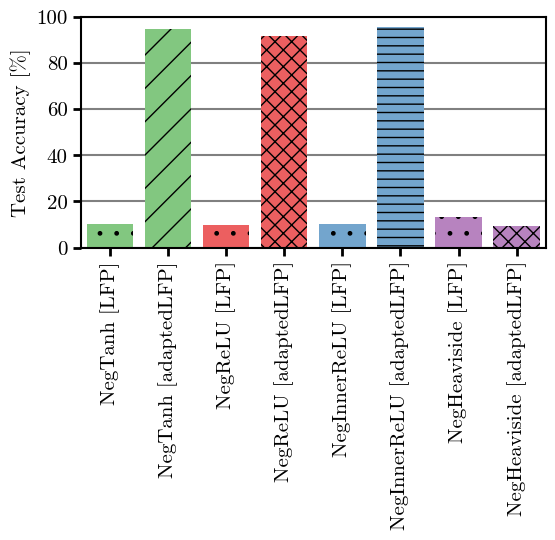

In [ ]:
# Plot Settings
# Set font properties.
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.cm as cm
import copy
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

colors = np.linspace(0, 1, 9)
palette = cm.get_cmap("Set1")(colors)
palette_tmp = copy.deepcopy(palette)
palette[0] = palette_tmp[2]
palette[1] = palette_tmp[0]
palette[2] = palette_tmp[1]
pastel = 0.3
palette = (1-pastel)*palette+pastel*np.ones((9, 4))

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

HATCHES = {
    propagator.LFPEpsilonComposite: ".",
    BothflipLFPEpsilonComposite: "/",
    NegflipLFPEpsilonComposite: "--",
    PosflipLFPEpsilonComposite: "xx",
}

ACTS = {
    "negtanh": "NegTanh", 
    "negrelu": "NegReLU", 
    "neginnerrelu": "NegInnerReLU", 
    "negstep": "NegHeaviside"
}

barloc = 0.5
xlabels = []
for a, act in enumerate(activations):
    for p, prop in enumerate(list(result_dict[act].keys())):
        sel_hatch = None
        for h, hatch in HATCHES.items():
            if isinstance(result_dict[act][prop][1], h):
                sel_hatch = hatch
        ax.bar(barloc, result_dict[act][prop][-1], color=palette[a], hatch=sel_hatch)
        xlabels.append(f"{ACTS[act]} [{prop}]")
        barloc += 1

linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.hlines(linelocs, xmin=-1, xmax=400, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

ax.set_ylim([0.0, 1.0])
ax.set_xlim([0, barloc-0.5])

ax.set_ylabel(f"Test Accuracy [%]")
ax.set_xlabel("")

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])

ax.set_xticks(np.arange(0.5, barloc-0.5, 1.0))
ax.set_xticklabels(xlabels, rotation=90)

ax.tick_params(length=6, width=2)
plt.show()